# 人脸识别模型 FaceNet


## 使用基于 NN4 改造的 CNN 模型训练和提取特征


**nn4.small2.v1** 是 FaceNet 论文中描述的 NN4 模型的变体，在 OpenFace 的模型列表中有 [nn4.small2](https://cmusatyalab.github.io/openface/models-and-accuracies/#model-definitions) 详细介绍。

![](model_comparison.png)


### 模型列表

|Model | Number of Parameters |
| ---- | ---- |
| [nn4.small2](https://github.com/cmusatyalab/openface/blob/master/models/openface/nn4.small2.def.lua) | 3733968 |
| [nn4.small1](https://github.com/cmusatyalab/openface/blob/master/models/openface/nn4.small1.def.lua) | 5579520 |
| [nn4](https://github.com/cmusatyalab/openface/blob/master/models/openface/nn4.def.lua) | 6959088 |
| [nn2](https://github.com/cmusatyalab/openface/blob/master/models/openface/nn2.def.lua) | 7472144 |


本教程使用其 [Keras版本](https://github.com/krasserm/face-recognition) 的一种实现，模型定义在 [model.py](model.py) ，模型可视化的图像存储在 [nn4_small2_model.png](nn4_small2_model.png) 。

### Retrain 人脸识别模型工作流程

1. 加载训练数据集
1. 人脸检测、对齐和提取（使用 OpenFace 的人脸对齐工具 AlignDlib）
1. 人脸特征向量学习（使用预训练的 nn4.small1.v1 模型)
1. 人脸分类（使用 KNN 或 SVM）


## 加载训练数据集

### 训练数据集组织形式

- 每人一个文件目录，目录以人名命名，如”Fan\_Bingbing“
- 每个人的文件目录下包含10张图像（最好是1:1比例），图像文件以"人名\_序号"命名，仅支持.jpg和.jpeg 两种格式。如”Fan\_Bingbing\_0001.jpg“。

In [1]:
import numpy as np

import cv2
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base # 数据集根目录
        self.name = name # 目录名
        self.file = file # 图像文件名

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # 检查文件名后缀，仅支持 jpg 和 jpeg 两种文件格式
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV 默认使用 BGR 通道加载图像，转换为 RGB 图像
    return img[...,::-1]

In [2]:
metadata = load_metadata('images')

In [3]:
print(metadata)

[images/Deng_chao/Deng_chao_0010.jpg images/Deng_chao/Deng_chao_0004.jpg
 images/Deng_chao/Deng_chao_0005.jpg images/Deng_chao/Deng_chao_0007.jpg
 images/Deng_chao/Deng_chao_0006.jpg images/Deng_chao/Deng_chao_0002.jpg
 images/Deng_chao/Deng_chao_0003.jpg images/Deng_chao/Deng_chao_0001.jpg
 images/Deng_chao/Deng_chao_0008.jpg images/Deng_chao/Deng_chao_0009.jpg
 images/Fan_Bingbing/Fan_Bingbing_0008.jpg
 images/Fan_Bingbing/Fan_Bingbing_0009.jpg
 images/Fan_Bingbing/Fan_Bingbing_0007.jpg
 images/Fan_Bingbing/Fan_Bingbing_0006.jpg
 images/Fan_Bingbing/Fan_Bingbing_0010.jpg
 images/Fan_Bingbing/Fan_Bingbing_0004.jpg
 images/Fan_Bingbing/Fan_Bingbing_0005.jpg
 images/Fan_Bingbing/Fan_Bingbing_0001.jpg
 images/Fan_Bingbing/Fan_Bingbing_0002.jpg
 images/Fan_Bingbing/Fan_Bingbing_0003.jpg
 images/Di_lireba/Di_Lireba_0006.jpg images/Di_lireba/Di_Lireba_0007.jpg
 images/Di_lireba/Di_Lireba_0005.jpg images/Di_lireba/Di_Lireba_0004.jpg
 images/Di_lireba/Di_Lireba_0010.jpg images/Di_lireba/Di_Li

## 人脸检测、对齐和提取

从原图提取 96x96 RGB人脸图像。如果原图不是 1:1 比例，提取后的人脸会进行拉伸变换。

([], <a list of 0 Text yticklabel objects>)

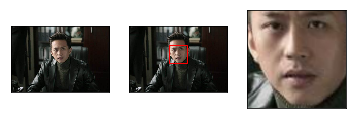

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

# 初始化 OpenFace 人脸对齐工具，使用 Dlib 提供的 68 个关键点
alignment = AlignDlib('face_detection/landmarks.dat')

# 加载一张训练图像
img = load_image(metadata[0].image_path())

# 检测人脸并返回边框
bb = alignment.getLargestFaceBoundingBox(img)

# 使用指定的人脸关键点转换图像并截取 96x96 的人脸图像
aligned_img = alignment.align(96, img, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# 绘制原图
plt.subplot(131)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

# 绘制带人脸边框的原图
plt.subplot(132)
plt.imshow(img)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))
plt.xticks([])
plt.yticks([])

# 绘制对齐后截取的 96x96 人脸图像
plt.subplot(133)
plt.imshow(aligned_img)
plt.xticks([])
plt.yticks([])

### 加载 nn4.small2.v1 模型

![](facenet_architect.png)

In [5]:
from model import create_model

nn4_small2 = create_model()

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer

# 输入 anchor, positive and negative 96x96 RGB图像
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# 输出对应的人脸特征向量
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

## Triplet Loss Layer

模型训练的目标是学习出一个将人脸图像嵌入到欧几里得特征空间的函数 $f(x)$，使得对于特定人脸图像 $x$ ，同一人不同人脸的欧式距离（Squared L2 Distance）尽可能小，不同人直接的欧式距离尽可能大。

通过最小化 *triplet loss* $L$ 可以学习到我们想要的模型：

$$L = \sum^{N}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$

$[z]_+$ 即 $max(z,0)$ , $N$ 是三元组集合的基数。

**下面使用 Keras 的自定义 Loss 来实现 Triplet Loss**

In [7]:
from tensorflow.keras import backend as K

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

## 加载预训练模型 nn4.small2.v1

我们从 OpenFace 提供的 [预训练模型](https://cmusatyalab.github.io/openface/models-and-accuracies/#pre-trained-models) 中选择 **nn4.small2.v1**。

这些模型使用公开数据集 [FaceScrub](http://vintage.winklerbros.net/facescrub.html) 和 [CASIA-WebFace](http://arxiv.org/abs/1411.7923)进行训练。Keras-OpenFace 项目将这些模型文件转换为 [csv 文件](https://github.com/iwantooxxoox/Keras-OpenFace/tree/master/weights)，然后我们将其转换为 Keras h5 模型文件 [nn4.small2.v1.h5](models/nn4.small2.v1.h5)。

### 预训练模型

| Model         | alignment `landmarkIndices`                    |
| ---- | ---- |
| nn4.v1        | `openface.AlignDlib.INNER_EYES_AND_BOTTOM_LIP` |
| nn4.v2        | `openface.AlignDlib.OUTER_EYES_AND_NOSE`       |
| nn4.small1.v1 | `openface.AlignDlib.OUTER_EYES_AND_NOSE`       |
| nn4.small2.v1 | `openface.AlignDlib.OUTER_EYES_AND_NOSE`       |


In [8]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('models/nn4.small2.v1.h5')

In [9]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [10]:
# 原数据集测试效果更好
#metadata = load_metadata('images')
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # 数据规范化
    img = (img / 255.).astype(np.float32)
    # 人脸特征向量
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

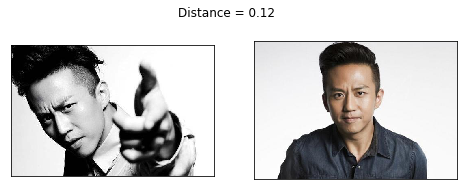

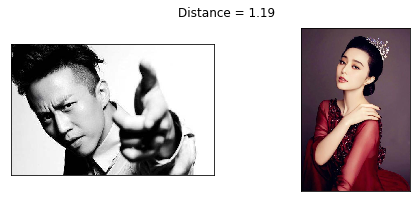

In [11]:
# Squared L2 Distance
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))
    plt.xticks([])
    plt.yticks([])


show_pair(2, 3)
show_pair(2, 12)

## 人脸分类

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.78, SVM accuracy = 0.76


([], <a list of 0 Text yticklabel objects>)

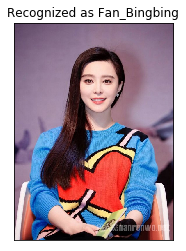

In [15]:
import warnings
warnings.filterwarnings('ignore')

# 测试不同样例
example_idx = 10

example_image = load_image(metadata[example_idx].image_path())
example_prediction = svc.predict([embedded[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');
plt.xticks([])
plt.yticks([])

## 模型测试与可视化分析

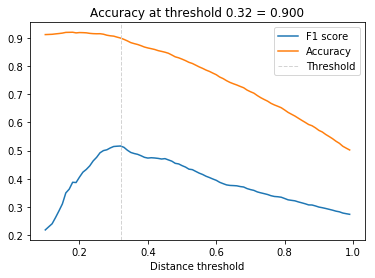

In [16]:
from sklearn.metrics import f1_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.1, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)

opt_tau = thresholds[opt_idx] # 最大F1值对应的 threshold

opt_acc = accuracy_score(identical, distances < opt_tau) # 最大F1值对应的准确率

# 绘制F1值和准确率与 threshold 间关系
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

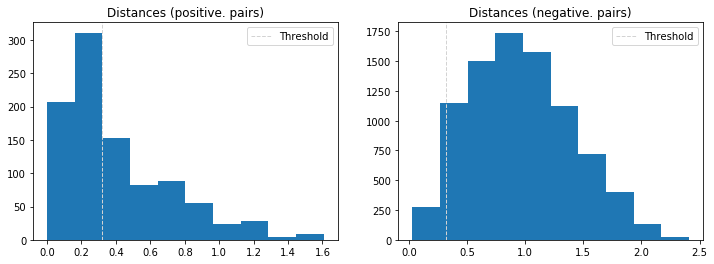

In [17]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (positive. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (negative. pairs)')

plt.legend();

## 降维人脸特征向量

([], <a list of 0 Text yticklabel objects>)

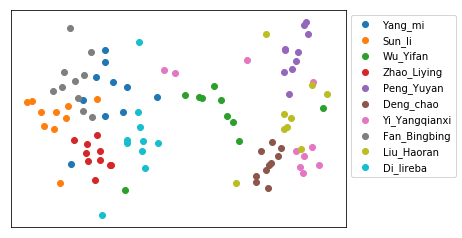

In [18]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));
plt.xticks([])
plt.yticks([])